In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jasonloiii","key":"7571a156ff0c02f9b34ece23216b5893"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!cat ~/.kaggle/kaggle.json

{"username":"jasonloiii","key":"7571a156ff0c02f9b34ece23216b5893"}

In [5]:
!kaggle datasets download -d abdelghaniaaba/wildfire-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
 99% 1.44G/1.45G [00:15<00:00, 34.0MB/s]
100% 1.45G/1.45G [00:16<00:00, 96.5MB/s]


In [6]:
!unzip wildfire-prediction-dataset.zip -d wildfire_dataset

Streaming output truncated to the last 5000 lines.
  inflating: wildfire_dataset/valid/nowildfire/-73.465183,45.443641.jpg  
  inflating: wildfire_dataset/valid/nowildfire/-73.465388,45.584881.jpg  
  inflating: wildfire_dataset/valid/nowildfire/-73.469451,45.480331.jpg  
  inflating: wildfire_dataset/valid/nowildfire/-73.471252,45.51974.jpg  
  inflating: wildfire_dataset/valid/nowildfire/-73.472693,45.427766.jpg  
  inflating: wildfire_dataset/valid/nowildfire/-73.473015,45.435254.jpg  
  inflating: wildfire_dataset/valid/nowildfire/-73.475051,45.56612.jpg  
  inflating: wildfire_dataset/valid/nowildfire/-73.477079,45.597274.jpg  
  inflating: wildfire_dataset/valid/nowildfire/-73.478813,45.555686.jpg  
  inflating: wildfire_dataset/valid/nowildfire/-73.479478,45.524618.jpg  
  inflating: wildfire_dataset/valid/nowildfire/-73.480135,45.528248.jpg  
  inflating: wildfire_dataset/valid/nowildfire/-73.480722,45.518864.jpg  
  inflating: wildfire_dataset/valid/nowildfire/-73.481149,45.56

In [7]:
import os

print("wildfire_dataset:")
print(os.listdir("wildfire_dataset"))

print("\n Train:")
print(os.listdir("wildfire_dataset/train")[:5])

print("\n Valid:")
print(os.listdir("wildfire_dataset/valid")[:5])

wildfire_dataset:
['train', 'test', 'valid']

 Train:
['wildfire', 'nowildfire']

 Valid:
['wildfire', 'nowildfire']


In [8]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU Available:", tf.test.gpu_device_name())
    except RuntimeError as e:
        print("Error setting memory growth:", e)
else:
    print("GPU Not Available - using CPU")

print(f"\nTensorFlow version: {tf.__version__}")


GPU Not Available - using CPU

TensorFlow version: 2.19.0


In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFile
import pickle
import json
import time
import hashlib
from pathlib import Path
import itertools
from datetime import datetime
import gc
import pandas as pd
import shutil
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [10]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def check_and_remove_corrupted(folder):
    removed = []
    for root, _, files in os.walk(folder):
        for f in files:
            if not f.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            path = os.path.join(root, f)
            try:
                img = Image.open(path)
                img.verify()
                img = Image.open(path)
                img.load()
            except:
                print(f"Removing corrupted: {path}")
                os.remove(path)
                removed.append(path)
    return removed

print("Checking train images...")
removed_train = check_and_remove_corrupted('wildfire_dataset/train')
print(f"Removed {len(removed_train)} corrupted train images")

print("\nChecking valid images...")
removed_valid = check_and_remove_corrupted('wildfire_dataset/valid')
print(f"Removed {len(removed_valid)} corrupted valid images")

print("\nImage cleanup complete!")

Checking train images...
Removed 0 corrupted train images

Checking valid images...
Removed 0 corrupted valid images

Image cleanup complete!


In [11]:
CHECKPOINT_DIR = '/content/checkpoints'
MODELS_DIR = '/content/models'
LOGS_DIR = '/content/logs'

for dir_path in [CHECKPOINT_DIR, MODELS_DIR, LOGS_DIR]:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

class HyperparameterCheckpoint:
    def __init__(self, checkpoint_dir=CHECKPOINT_DIR):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.main_checkpoint = self.checkpoint_dir / "main_checkpoint.pkl"
        self.backup_checkpoint = self.checkpoint_dir / "backup_checkpoint.pkl"
        self.progress_log = self.checkpoint_dir / "progress.json"

    def create_param_hash(self, params):
        param_str = str(sorted(params))
        return hashlib.md5(param_str.encode()).hexdigest()[:8]

    def save_checkpoint(self, data):
        timestamp = datetime.now().isoformat()

        checkpoint_data = {
            'results': data.get('results', []),
            'best_accuracy': data.get('best_accuracy', 0),
            'best_params': data.get('best_params', {}),
            'completed_configs': data.get('completed_configs', 0),
            'tested_combinations': data.get('tested_combinations', []),
            'last_update': timestamp,
            'total_training_time': data.get('total_training_time', 0)
        }

        try:
            if self.main_checkpoint.exists():
                shutil.copy2(self.main_checkpoint, self.backup_checkpoint)

            with open(self.main_checkpoint, 'wb') as f:
                pickle.dump(checkpoint_data, f)

            with open(self.progress_log, 'w') as f:
                json.dump({
                    'completed': data['completed_configs'],
                    'best_accuracy': data['best_accuracy'],
                    'best_params': data['best_params'],
                    'last_update': timestamp
                }, f, indent=2)

            print(f"Checkpoint saved")
            return True
        except Exception as e:
            print(f"Error saving checkpoint: {e}")
            return False

    def load_checkpoint(self):
        try:
            if self.main_checkpoint.exists():
                with open(self.main_checkpoint, 'rb') as f:
                    data = pickle.load(f)
                print(f"Loaded checkpoint - {data['completed_configs']} configs completed")
                return data
        except Exception as e:
            print(f"Main checkpoint corrupted: {e}")
            try:
                if self.backup_checkpoint.exists():
                    with open(self.backup_checkpoint, 'rb') as f:
                        data = pickle.load(f)
                    print(f"Loaded backup checkpoint")
                    return data
            except:
                pass

        print("Starting fresh")
        return {
            'results': [],
            'best_accuracy': 0,
            'best_params': {},
            'completed_configs': 0,
            'tested_combinations': [],
            'total_training_time': 0
        }

    def get_remaining_combinations(self, all_combinations, tested_combinations):
        tested_hashes = {self.create_param_hash(combo) for combo in tested_combinations}
        remaining = [combo for combo in all_combinations
                    if self.create_param_hash(combo) not in tested_hashes]
        return remaining

checkpoint_manager = HyperparameterCheckpoint()
print("Checkpoint system ready!")
print(f"Checkpoints: {CHECKPOINT_DIR}")
print(f"Models: {MODELS_DIR}")
print(f"Logs: {LOGS_DIR}")


Checkpoint system ready!
Checkpoints: /content/checkpoints
Models: /content/models
Logs: /content/logs


In [12]:
import itertools

fixed_params = {
    'learning_rate': 5e-5,
    'batch_size': 32,
    'epochs': 5,
    'dropout_rate': 0.4,
    'dense_units': 128
}

all_combinations = [tuple(fixed_params.values())]
global total_combinations
total_combinations = 1

print(f"   Fixed Parameters Setup:")
print(f"   Total configurations (single run): {total_combinations}")
print(f"\n Parameters:")
for key, value in fixed_params.items():
    print(f"   {key}: {value}")

checkpoint_data = checkpoint_manager.load_checkpoint()

remaining = all_combinations if not checkpoint_data['completed_configs'] else []

print(f"\n Setup complete!")
print(f"   Completed: {checkpoint_data['completed_configs']}/{total_combinations}")
print(f"   Remaining: {len(remaining)} configurations")
print(f"   Best so far: {checkpoint_data['best_accuracy']:.4f}")

   Fixed Parameters Setup:
   Total configurations (single run): 1

 Parameters:
   learning_rate: 5e-05
   batch_size: 32
   epochs: 5
   dropout_rate: 0.4
   dense_units: 128
Starting fresh

 Setup complete!
   Completed: 0/1
   Remaining: 1 configurations
   Best so far: 0.0000


In [13]:
def train_configuration(params, config_index, checkpoint_data):
    lr, batch_size, epochs, dropout_rate, dense_units = params
    param_hash = checkpoint_manager.create_param_hash(params)

    print(f"\n{'='*70}")
    print(f"Config #{config_index+1}/{len(all_combinations)} | Hash: {param_hash}")
    print(f"LR={lr}, BS={batch_size}, Epochs={epochs}, DR={dropout_rate}, DU={dense_units}")
    print(f"{'='*70}")

    training_start = time.time()

    try:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            brightness_range=[0.8, 1.2],
            fill_mode='nearest'
        )

        valid_datagen = ImageDataGenerator(rescale=1./255)

        train_gen = train_datagen.flow_from_directory(
            'wildfire_dataset/train',
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True
        )

        valid_gen = valid_datagen.flow_from_directory(
            'wildfire_dataset/valid',
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )

        tf.keras.backend.clear_session()

        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False

        for layer in base_model.layers[-10:]:
            layer.trainable = True

        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
        x = Dropout(dropout_rate)(x)
        predictions = Dense(2, activation='softmax')(x)

        model = Model(inputs=base_model.input, outputs=predictions)

        model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-7, verbose=1)

        history = model.fit(
            train_gen,
            epochs=epochs,
            validation_data=valid_gen,
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )

        valid_gen.reset()
        y_pred_probs = model.predict(valid_gen, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = valid_gen.classes

        training_time = time.time() - training_start

        val_accuracy = max(history.history['val_accuracy'])
        val_loss = min(history.history['val_loss'])
        actual_epochs = len(history.history['val_accuracy'])

        result = {
            'param_hash': param_hash,
            'learning_rate': lr,
            'batch_size': batch_size,
            'epochs': epochs,
            'dropout_rate': dropout_rate,
            'dense_units': dense_units,
            'val_accuracy': val_accuracy,
            'val_loss': val_loss,
            'actual_epochs': actual_epochs,
            'training_time': training_time,
            'config_index': config_index,
            'timestamp': datetime.now().isoformat(),
            'y_true': y_true.tolist(),
            'y_pred': y_pred.tolist()
        }

        if val_accuracy > checkpoint_data.get('best_accuracy', 0):
            model_path = Path(MODELS_DIR) / f"best_model_{param_hash}_acc{val_accuracy:.4f}.h5"
            model.save(str(model_path))
            result['model_path'] = str(model_path)
            print(f"NEW BEST MODEL! Acc={val_accuracy:.4f}")

        print(f" Acc={val_accuracy:.4f}, Loss={val_loss:.4f}, Time={training_time/60:.1f}min")

        del model, train_gen, valid_gen, base_model
        tf.keras.backend.clear_session()
        gc.collect()

        return result

    except Exception as e:
        training_time = time.time() - training_start
        print(f" Error: {e}")

        tf.keras.backend.clear_session()
        gc.collect()

        return {
            'param_hash': param_hash,
            'learning_rate': lr,
            'batch_size': batch_size,
            'epochs': epochs,
            'dropout_rate': dropout_rate,
            'dense_units': dense_units,
            'val_accuracy': 0,
            'val_loss': float('inf'),
            'error': str(e),
            'training_time': training_time
        }

print("Training function ready!")

Training function ready!


In [14]:
print(" Starting Fine-Tuning with Fixed Parameters...")
print("="*70)

checkpoint_data = checkpoint_manager.load_checkpoint()
results = []
best_accuracy = 0
best_params = {}
completed_configs = 0
tested_combinations = []
total_training_time = 0

print(f"   Status:")
print(f"   Total: 1 configuration")
print(f"   Completed: 0")
print(f"   Remaining: 1")
print(f"   Best accuracy so far: 0.0000")
print("="*70)

session_start = time.time()

combination = all_combinations[0]
idx = 0

result = train_configuration(combination, completed_configs, checkpoint_data)

results.append(result)
tested_combinations.append(combination)
completed_configs += 1
total_training_time += result.get('training_time', 0)

best_accuracy = result['val_accuracy']
best_params = {k: v for k, v in result.items()
              if k not in ['timestamp', 'training_time', 'config_index', 'y_true', 'y_pred']}

checkpoint_data.update({
    'results': results,
    'best_accuracy': best_accuracy,
    'best_params': best_params,
    'completed_configs': completed_configs,
    'tested_combinations': tested_combinations,
    'total_training_time': total_training_time
})

checkpoint_manager.save_checkpoint(checkpoint_data)

progress = (completed_configs / total_combinations) * 100
print(f"\n Progress: {completed_configs}/{total_combinations} ({progress:.1f}%)")
print(f" Current best: {best_accuracy:.4f}")
print(f" Session time: {(time.time() - session_start)/3600:.1f}h")
print("-"*70)

print("\n Fine-tuning session completed!")
print(f" All progress saved to: {CHECKPOINT_DIR}")

 Starting Fine-Tuning with Fixed Parameters...
Starting fresh
   Status:
   Total: 1 configuration
   Completed: 0
   Remaining: 1
   Best accuracy so far: 0.0000

Config #1/1 | Hash: 574e52e6
LR=5e-05, BS=32, Epochs=5, DR=0.4, DU=128
Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 2634s 3s/step - accuracy: 0.8985 - loss: 0.4741 - val_accuracy: 0.9405 - val_loss: 0.3939 - learning_rate: 5.0000e-05
Epoch 2/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 2616s 3s/step - accuracy: 0.9435 - loss: 0.3515 - val_accuracy: 0.9497 - val_loss: 0.3518 - learning_rate: 5.0000e-05
Epoch 3/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 2524s 3s/step - accuracy: 0.9494 - loss: 0.3148 - val_accuracy: 0.9597 - val_loss: 0.2828 - learning_rate: 5.0000e-05
Epoch 4/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 2392s 3s/step - accuracy: 0.9526 - loss: 0.2834 - val_accuracy: 0.9660 - val_loss: 0.2492 - learning_rate: 5.0000e-05
Epoch 5/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 2441s 3s/step - accuracy: 0.9593 - loss: 0.2524 - val_accuracy: 0.9627 - val_loss: 0.2390 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 5.


NEW BEST MODEL! Acc=0.9660
 Acc=0.9660, Loss=0.2390, Time=215.1min
Checkpoint saved

 Progress: 1/1 (100.0%)
 Current best: 0.9660
 Session time: 3.6h
----------------------------------------------------------------------

 Fine-tuning session completed!
 All progress saved to: /content/checkpoints


Loaded checkpoint - 1 configs completed
 FINE-TUNING RESULT

   Accuracy: 0.9660 | Loss: 0.2390
     LR: 0.000050 | Batch: 32 | 
     Dropout: 0.4 | Dense: 128
     Epochs: 5 | Time: 215.1min

 BINARY EVALUATION (Confusion Matrix + Precision + Recall + F1)

CONFUSION MATRIX (2×2):

[[2767   53]
 [ 182 3298]]

TP: 3298, TN: 2767, FP: 53, FN: 182

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0     0.9383    0.9812    0.9593      2820
           1     0.9842    0.9477    0.9656      3480

    accuracy                         0.9627      6300
   macro avg     0.9612    0.9645    0.9624      6300
weighted avg     0.9636    0.9627    0.9628      6300



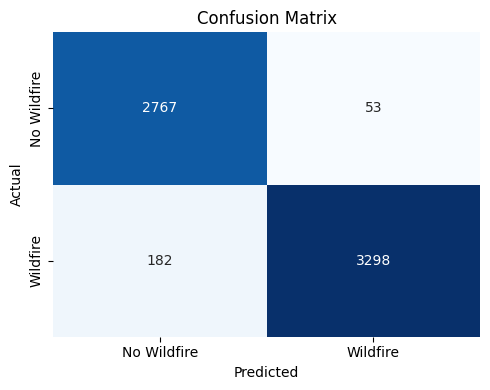


Confusion matrix saved to /content/logs/confusion_matrix.png

 PARAMETER ANALYSIS
 (Single configuration, no comparative analysis across parameters)

 Detailed results saved: /content/logs/detailed_results_20251126_183736.csv

 SUMMARY
Total configurations tested: 1
Achieved accuracy: 0.9660
Total training time: 3.59 hours

 Analysis complete!


In [15]:

from sklearn.metrics import confusion_matrix, classification_report

checkpoint_manager = HyperparameterCheckpoint()

checkpoint_data = checkpoint_manager.load_checkpoint()
results = checkpoint_data['results']

if not results:
    print(" No results yet. Run the fine-tuning first!")
    exit()

successful_results = [r for r in results if 'error' not in r and r['val_accuracy'] > 0]

if not successful_results:
    print(" No successful results found after fine-tuning.")
    exit()

results_df = pd.DataFrame(successful_results)
results_df = results_df.sort_values('val_accuracy', ascending=False)


print("="*80)
print(" FINE-TUNING RESULT")
print("="*80)
row = results_df.iloc[0]
print(f"\n   Accuracy: {row['val_accuracy']:.4f} | Loss: {row['val_loss']:.4f}")
print(f"     LR: {row['learning_rate']:.6f} | Batch: {row['batch_size']} | ")
print(f"     Dropout: {row['dropout_rate']} | Dense: {row['dense_units']}")
print(f"     Epochs: {row['actual_epochs']} | Time: {row['training_time']/60:.1f}min")


print("\n" + "="*80)
print(" BINARY EVALUATION (Confusion Matrix + Precision + Recall + F1)")
print("="*80)

best = results_df.iloc[0]

if 'y_true' in best and 'y_pred' in best:
    y_true = best["y_true"]
    y_pred = best["y_pred"]

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print("\nCONFUSION MATRIX (2×2):\n")
    print(cm)
    print(f"\nTP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

    print("\nCLASSIFICATION REPORT:\n")
    print(classification_report(y_true, y_pred, digits=4))

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Wildfire', 'Wildfire'], yticklabels=['No Wildfire', 'Wildfire'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.savefig(f"{LOGS_DIR}/confusion_matrix.png", dpi=150)
    plt.show()

    print(f"\nConfusion matrix saved to {LOGS_DIR}/confusion_matrix.png")
elif 'error' in best:
    print(f"Confusion matrix and classification report not available due to an error during training: {best['error']}")
else:
    print("Confusion matrix and classification report not available: 'y_true' or 'y_pred' missing in results.")


print(f"\n{'='*80}")
print(" PARAMETER ANALYSIS")
print("="*80)
print(" (Single configuration, no comparative analysis across parameters)")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_path = f'{LOGS_DIR}/detailed_results_{timestamp}.csv'
results_df.to_csv(results_path, index=False)

print(f"\n Detailed results saved: {results_path}")

print("\n" + "="*80)
print(" SUMMARY")
print("="*80)
print(f"Total configurations tested: {len(successful_results)}")
print(f"Achieved accuracy: {results_df['val_accuracy'].max():.4f}")
print(f"Total training time: {checkpoint_data['total_training_time']/3600:.2f} hours")

print("\n Analysis complete!")

 Loading best model: best_model_574e52e6_acc0.9660.h5


 Best model loaded successfully!
Loaded checkpoint - 1 configs completed

 Best Model Performance:
   Accuracy: 0.9660

 Best Parameters:
   learning_rate: 5e-05
   batch_size: 32
   epochs: 5
   dropout_rate: 0.4
   dense_units: 128
   val_accuracy: 0.9660317301750183
   val_loss: 0.23900291323661804
   actual_epochs: 5

 Testing on validation samples...

 Testing No Wildfire samples:

--- Sample 1 (No Wildfire) ---


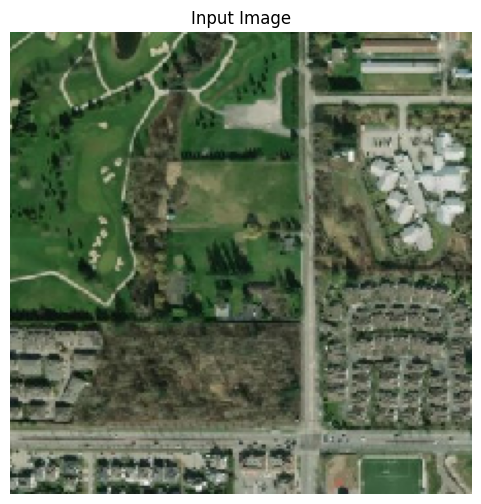


 Prediction: No Wildfire
   Confidence: 100.00%
   Probabilities:
   No Wildfire: 100.00%
   Wildfire: 0.00%

--- Sample 2 (No Wildfire) ---


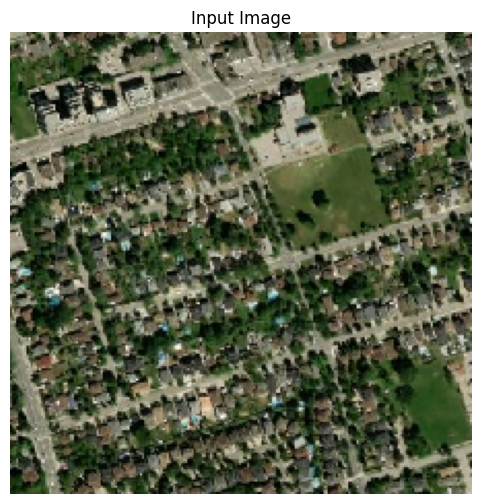


 Prediction: No Wildfire
   Confidence: 100.00%
   Probabilities:
   No Wildfire: 100.00%
   Wildfire: 0.00%

 Testing Wildfire samples:

--- Sample 1 (Wildfire) ---


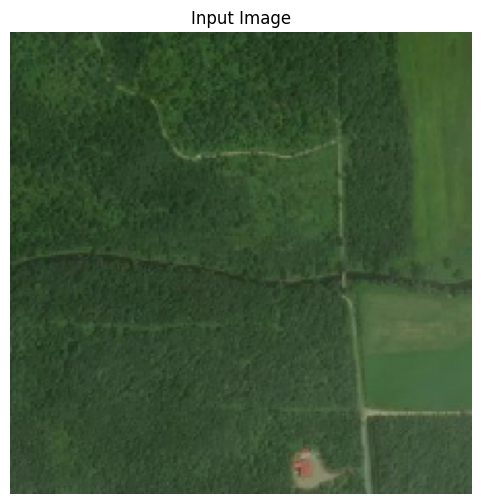


 Prediction: Wildfire
   Confidence: 99.90%
   Probabilities:
   No Wildfire: 0.10%
   Wildfire: 99.90%

--- Sample 2 (Wildfire) ---


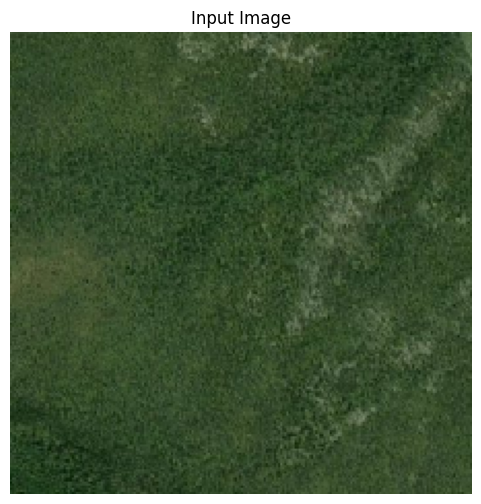


 Prediction: Wildfire
   Confidence: 99.99%
   Probabilities:
   No Wildfire: 0.01%
   Wildfire: 99.99%

 Testing complete!

 To predict on your own image:
   predict_wildfire('path/to/image.jpg', best_model)


In [16]:
model_files = list(Path(MODELS_DIR).glob("*.h5"))

if not model_files:
    print(" No models found. Train first!")
else:
    best_model_file = max(model_files,
                         key=lambda x: float(x.stem.split('acc')[-1]) if 'acc' in x.stem else 0)

    print(f" Loading best model: {best_model_file.name}")
    best_model = load_model(str(best_model_file))

    print(" Best model loaded successfully!")

    checkpoint_data = checkpoint_manager.load_checkpoint()
    print(f"\n Best Model Performance:")
    print(f"   Accuracy: {checkpoint_data['best_accuracy']:.4f}")
    print(f"\n Best Parameters:")
    for key, value in checkpoint_data['best_params'].items():
        if key not in ['timestamp', 'model_path', 'param_hash', 'history_path', 'config_index']:
            print(f"   {key}: {value}")

    def predict_wildfire(img_path, model, show_img=True):
        img = image.load_img(img_path, target_size=(224, 224))

        if show_img:
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title('Input Image')
            plt.show()

        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        predictions = model.predict(img_array, verbose=0)
        predicted_class = np.argmax(predictions[0])
        confidence = np.max(predictions[0])

        class_names = ["No Wildfire", "Wildfire"]

        print(f"\n Prediction: {class_names[predicted_class]}")
        print(f"   Confidence: {confidence*100:.2f}%")
        print(f"   Probabilities:")
        print(f"   No Wildfire: {predictions[0][0]*100:.2f}%")
        print(f"   Wildfire: {predictions[0][1]*100:.2f}%")

        return class_names[predicted_class], confidence

    print("\n" + "="*70)
    print(" Testing on validation samples...")
    print("="*70)

    valid_nowildfire_dir = Path('wildfire_dataset/valid/nowildfire')
    valid_wildfire_dir = Path('wildfire_dataset/valid/wildfire')

    if valid_nowildfire_dir.exists() and valid_wildfire_dir.exists():
        nowildfire_samples = list(valid_nowildfire_dir.glob('*.jpg'))[:2]
        wildfire_samples = list(valid_wildfire_dir.glob('*.jpg'))[:2]

        print("\n Testing No Wildfire samples:")
        for i, sample in enumerate(nowildfire_samples, 1):
            print(f"\n--- Sample {i} (No Wildfire) ---")
            predict_wildfire(str(sample), best_model, show_img=True)

        print("\n Testing Wildfire samples:")
        for i, sample in enumerate(wildfire_samples, 1):
            print(f"\n--- Sample {i} (Wildfire) ---")
            predict_wildfire(str(sample), best_model, show_img=True)

    print("\n" + "="*70)
    print(" Testing complete!")

    globals()['predict_wildfire'] = predict_wildfire
    globals()['best_model'] = best_model

    print("\n To predict on your own image:")
    print("   predict_wildfire('path/to/image.jpg', best_model)")

In [17]:
from google.colab import files
import zipfile
import shutil

checkpoint_manager = HyperparameterCheckpoint()

def create_results_package():
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    package_dir = Path(f"/content/results_package_{timestamp}")
    package_dir.mkdir(exist_ok=True)

    print(" Creating results package...")

    model_files = list(Path(MODELS_DIR).glob("*.h5"))
    if model_files:
        best_model_file = max(model_files,
                             key=lambda x: float(x.stem.split('acc')[-1]) if 'acc' in x.stem else 0)
        shutil.copy2(best_model_file, package_dir / "best_model.h5")
        print(f" Best model copied: {best_model_file.name}")
    else:
        print(" No model found to copy.")

    checkpoint_data = checkpoint_manager.load_checkpoint()

    summary_path = package_dir / "training_summary.txt"
    with open(summary_path, 'w') as f:
        f.write("WILDFIRE DETECTION - FINE-TUNING REPORT\n")
        f.write("="*70 + "\n\n")
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Configuration Tested: {checkpoint_data['completed_configs']}/{total_combinations}\n")
        f.write(f"Total Training Time: {checkpoint_data['total_training_time']/3600:.2f} hours\n")
        f.write(f"Achieved Validation Accuracy: {checkpoint_data['best_accuracy']:.4f}\n\n")

        f.write("FIXED PARAMETERS:\n")
        f.write("-"*40 + "\n")
        for key, value in checkpoint_data['best_params'].items():
            if key not in ['timestamp', 'model_path', 'param_hash', 'history_path', 'config_index', 'val_accuracy', 'val_loss', 'actual_epochs', 'training_time']:
                f.write(f"{key}: {value}\n")

        results = checkpoint_data['results']
        if results:
            single_result = results[0]
            f.write("\nSINGLE CONFIGURATION DETAILS:\n")
            f.write("-"*40 + "\n")
            f.write(f"Accuracy: {single_result['val_accuracy']:.4f}\n")
            f.write(f"Loss: {single_result['val_loss']:.4f}\n")
            f.write(f"Actual Epochs: {single_result['actual_epochs']}\n")
            f.write(f"Training Time: {single_result['training_time']/60:.1f} minutes\n")
        else:
            f.write("\nNo detailed results available for the single configuration.\n")

    print(" Summary report created")

    csv_files = list(Path(LOGS_DIR).glob("*.csv"))
    if csv_files:
        latest_csv = max(csv_files, key=lambda x: x.stat().st_mtime)
        shutil.copy2(latest_csv, package_dir / "detailed_results.csv")
        print(" CSV results copied")
    else:
        print(" No CSV results file found.")


    plot_files = list(Path(LOGS_DIR).glob("*.png"))
    if plot_files:
        for plot in plot_files:
            shutil.copy2(plot, package_dir / plot.name)
        print(f" Visualizations copied")
    else:
        print(" No visualizations found to copy.")


    if checkpoint_manager.main_checkpoint.exists():
        shutil.copy2(checkpoint_manager.main_checkpoint, package_dir / "checkpoint.pkl")
        print(" Checkpoint copied")
    else:
        print(" Main checkpoint file not found.")

    zip_path = f"/content/wildfire_results_{timestamp}.zip"
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file_path in package_dir.rglob('*'):
            if file_path.is_file():
                zipf.write(file_path, file_path.relative_to(package_dir))

    zip_size = Path(zip_path).stat().st_size / (1024 * 1024)

    print(f"\n{'='*70}")
    print(f" Package created successfully!")
    print(f" Size: {zip_size:.2f} MB")
    print(f"{'='*70}")

    return zip_path

print(" Creating downloadable results package...\n")

package_path = create_results_package()

print("\n Downloading...")
files.download(package_path)

print("\n Download complete!")

 Creating downloadable results package...

 Creating results package...
 Best model copied: best_model_574e52e6_acc0.9660.h5
Loaded checkpoint - 1 configs completed
 Summary report created
 CSV results copied
 Visualizations copied
 Checkpoint copied

 Package created successfully!
 Size: 14.96 MB

 Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 Download complete!
